In [3]:
!python --version

Python 3.11.0


In [1]:
import brian2 as b2
from brian2 import *
import matplotlib.pyplot as plt



In [2]:
# TODO: Make weights always non-negative!

# Parameters for neurons
Cm = 281 * pF  # Membrane capacitance
gL = 30 * nS   # Leak conductance
EL = -70.6 * mV  # Leak reversal potential
Vth = -50.4 * mV  # Spike threshold
DeltaT = 2 * mV  # Slope factor
Vr = -70.6 * mV  # Reset potential
Vcut = -40 * mV  # Cutoff potential for spike generation
tau_A = 1 * ms  # Adaptation time constant
c = 4 * nS       # Coupling parameter
b = 0.0805 * nA  # Spike-triggered adaptation increment

# Parameters for synapses
tau_rise = 5 * ms  # Rise time constant for AMPA
tau_decay = 50 * ms  # Decay time constant for NMDA
w_init = 0.5 * nS   # Initial synaptic weight (conductance)

# AdEx neuron equations
eqs = '''
dv/dt = ( -gL * (v - EL) + gL * DeltaT * exp((v - Vth) / DeltaT) + I - A ) / Cm : volt
dA/dt = (c * (v - EL) - A) / tau_A : amp

I : amp  # Input current
'''

# Synapse equations (Spike trace dynamics)
syn_eqs_exc = '''
dX/dt = -X / tau_decay + Y / tau_rise : volt   # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
'''
# Isyn_exc = w * X * (v_post - EL) : amp 
syn_eqs_inh = '''
dX/dt = -X / tau_decay + Y / tau_rise : volt  # Spike trace
dY/dt = -Y / tau_decay : volt  # Glutamate decay
w : siemens  # Synaptic weight (conductance)
I_post = w * X : amp (summed)
'''




INFO       The synaptic equation for the variable X does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
INFO       The synaptic equation for the variable Y does not specify whether it should be integrated at every timestep ('clock-driven') or only at spiking events ('event-driven'). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]
cl : warning della riga di comando D9025 : override di '/W3' con '/w'
WARNING    Cannot use Cython

_cython_magic_32a1cdc0f6fb3e035c7e07036edf98c2.cpp
_cython_magic_32a1cdc0f6fb3e035c7e07036edf98c2.obj : warning LNK4197: esportazione 'PyInit__cython_magic_32a1cdc0f6fb3e035c7e07036edf98c2' specificata più volte; verrà utilizzata la prima specifica
   Creazione della libreria C:\Users\bruno\.cython\brian_extensions\Users\bruno\.cython\brian_extensions\_cython_magic_32a1cdc0f6fb3e035c7e07036edf98c2.cp311-win_amd64.lib e dell'oggetto C:\Users\bruno\.cython\brian_extensions\Users\bruno\.cython\brian_extensions\_cython_magic_32a1cdc0f6fb3e035c7e07036edf98c2.cp311-win_amd64.exp
Generazione codice in corso...
Generazione codice terminata
LINK : fatal error LNK1158: impossibile eseguire 'rc.exe'


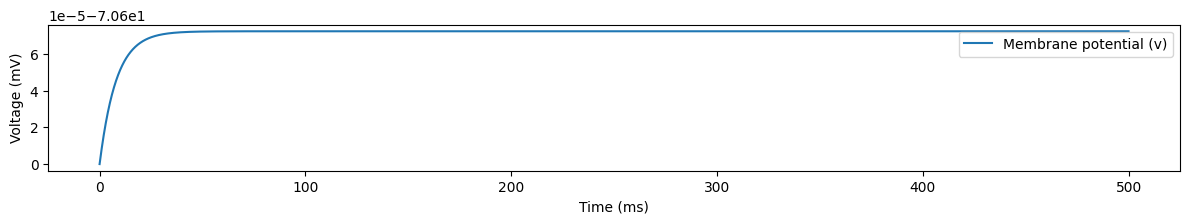

In [3]:
# Let's connect 2 groups as a trial

G1 = NeuronGroup(5, 'v : volt', threshold='v > Vcut', reset='v = Vr', method='euler')  # Presynaptic neurons
G2 = NeuronGroup(5, eqs, threshold='v > Vcut', reset='v = Vr; A += b', method='euler')  # Postsynaptic neurons

# Initialize variables
G1.v = EL
G2.v = EL
G2.A = 0 * nA

# Create synapses
S = Synapses(G1, G2, model=syn_eqs_exc,
             on_pre='Y = 1*volt', method = "euler")  # Increment glutamate release on spike
S.connect(p=0.1)  # Random connections
S.w = 'rand() * w_init'  # Random initial weights

# Monitors
spike_mon_G1 = SpikeMonitor(G1)
spike_mon_G2 = SpikeMonitor(G2)
state_mon_G2 = StateMonitor(G2, ['v', 'I', 'A'], record=True)

# Run simulation
b2.run(500 * ms)

plt.figure(figsize=(12, 6))

# Plot membrane potential of a postsynaptic neuron
plt.subplot(311)
plt.plot(state_mon_G2.t / ms, state_mon_G2.v[0] / mV, label='Membrane potential (v)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()


plt.tight_layout()
plt.show()

In [4]:
# dims = [784,400,225,64]
dims = [50,40,30,20]

gist_dim = 16



def make_groups(dims):

  groups = []

  for dim in dims:

     groups.append(NeuronGroup(dim, eqs, threshold='v > Vcut', reset='v = Vr', method='euler'))

  for group in groups:
     group.v = EL


  return groups

In [5]:
Rs = make_groups(dims)
Es_0 = make_groups(dims)
Es_1 = make_groups(dims)

In [6]:
def make_bottom_up_connections(Rs, Es_0, Es_1, syn_eqs_exc, syn_eqs_inh):


  S_p = Synapses(Rs, Es_0, model=syn_eqs_exc,
        on_pre='Y = 1')
  S_p.connect(condition='i == j')  # One-to-one connections
  S_p.w = 'w_init'


  S_m = Synapses(Rs, Es_1, model=syn_eqs_inh,
        on_pre='Y = 1*volt')
  S_m.connect(condition='i == j')  # One-to-one connections
  S_m.w = 'w_init'

  return S_p, S_m

In [7]:
S_p, S_m = make_bottom_up_connections(Rs[0], Es_0[0], Es_1[0], syn_eqs_exc, syn_eqs_inh)

In [8]:
def make_top_down_connections(Rs, Es_0, Es_1, syn_eqs_exc, syn_eqs_inh):


  S_p = Synapses(Rs, Es_1, model=syn_eqs_exc,
        on_pre='Y = 1*volt')
  S_p.connect()
  S_p.w = 'rand() * w_init'


  S_m = Synapses(Rs, Es_0, model=syn_eqs_inh,
        on_pre='Y = 1*volt')
  S_m.connect()
  S_m.w = 'rand() * w_init'


  return S_p, S_m

In [13]:
def make_gist_connections(Rs, G):

  S = Synapses(Rs[0], G, model=syn_eqs_exc,
        on_pre='Y = 1*volt')
  S.connect(p=0.05)  # Connect with 5% probability
  S.w = 'rand() * w_init'   # This is slightly different from the paper: it should be based on a ratio

  S_gist_input = S

  for R in Rs[1:]:
    S = Synapses(G, R, model=syn_eqs_exc,
        on_pre='Y = 1*volt')
    S.connect(p=0.05)  # Connect with 5% probability
    S_gist_output = S

  return S_gist_input, S_gist_output

In [14]:
# num_classes_per_layer and max_depth depend on the same parameters used when generating the datset

def make_output_layer(num_classes_per_layer, max_depth, w_out_init = None ):

    if w_out_init == None:
        w_out_init = w_init/10
        
        Os = []
    for d in range(0, max_depth):
        Os.append(NeuronGroup(N=num_classes_per_layer**(d), model = eqs, threshold='v > Vcut', reset='v = Vr', method='euler'))
        
    for d in range(1, max_depth):
        if d>1:
            S_o = Synapses(Os[d-1], Os[d], model=syn_eqs_exc,
            on_pre='Y = 1*volt')
            S_o.connect(condition='i < j/num_classes_per_layer')  # Hierarchical connections (hopefully)
            S_o.w = 'w_out_init'

    return Os, S_o





In [21]:

def make_network(dims, syn_eqs_exc, syn_eqs_inh, num_classes_per_layer, max_depth, w_out_init = None ):
    
    Rs = make_groups(dims)
    Es_0 = make_groups(dims)
    Es_1 = make_groups(dims)
    G = NeuronGroup(gist_dim, eqs, threshold='v > Vcut', reset='v = Vr', method='euler')
    
    Os, S_o_internal = make_output_layer(num_classes_per_layer, max_depth) # Hopefully this is correct
    
    connections = {}
    connections["output_internal"] = S_o_internal
    
    for i in range(len(Rs)):
    
    
        S_p, S_m = make_bottom_up_connections(Rs[i], Es_0[i], Es_1[i], syn_eqs_exc, syn_eqs_inh)
        
        connections[f"bottom_up_{i}"] = [S_p, S_m]
    
    if i != len(Rs)-1:
    
        S_p, S_m = make_top_down_connections(Rs[i+1], Es_0[i], Es_1[i], syn_eqs_exc, syn_eqs_inh)
        
        connections[f"top_down_{i}"] = [S_p, S_m]
    
    S_gist_input, S_gist_output = make_gist_connections(Rs, G)
    
    connections["gist_input"] = S_gist_input
    connections["gist_output"] = S_gist_output
    
    '''
    S_o_external = Synapses(Rs[-1], Os, model=syn_eqs_exc,
        on_pre='Y = 1*volt')
    S_o_external.connect()
    S_o_external.w = 'rand() * w_init'
    '''
    S_o_external = []
    for O in Os:
        S = Synapses(Rs[-1], O, model=syn_eqs_exc, on_pre='Y = 1*volt')
        S.connect()
        S.w = 'rand() * w_init'
        S_o_external.append(S)
    connections["output_external"] = S_o_external


    return Rs, Es_0, Es_1, G, Os, connections




In [22]:
connections = make_network(dims, syn_eqs_exc, syn_eqs_inh, num_classes_per_layer=3, max_depth=3)

In [23]:
from dataset_util import Synthetic_Dataset_Utils

ModuleNotFoundError: No module named 'torch'

In [ ]:
def training_phase_1(network, dataset):

  for curve, label in dataset:
    ...